In [48]:
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler

In [49]:
TICKER = "SOL-USD"
TIME_PERIOD = "7d"
TIME_INTERVAL = "5m"

In [50]:
def GetData(LOOKBACK, dataset_gold, ss):
  dataset_gold['Target'] = dataset_gold['Close']-dataset_gold.Open
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]

  x = np.reshape(np.array(dataset_gold['Target']), (-1, 1))
  x = np.reshape(ss.fit_transform(x), (-1))


  x_open = dataset_gold['Close'].values[-LOOKBACK:]


  split_len = int(len(x) * 0.8)
  x_train, x_test = x[:split_len],  x[split_len:]

  x_batch = []
  y_batch = []
  x_train_batch, y_train_batch = [], []
  x_test_batch, y_test_batch = [], []


  for i in range(len(x) - LOOKBACK):
    x_batch.append(x[i:LOOKBACK + i])
    y_batch.append(x[LOOKBACK + i])



  x_train_batch, x_test_batch = np.array(x_batch[:split_len]),  np.array(x_batch[split_len:])
  y_train_batch, y_test_batch = np.array(y_batch[:split_len]),  np.array(y_batch[split_len:])


  x_train_batch, y_train_batch = torch.FloatTensor(x_train_batch), torch.FloatTensor(y_train_batch)
  x_test_batch, y_test_batch = torch.FloatTensor(x_test_batch), torch.FloatTensor(y_test_batch)

  return x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch

In [51]:
LOOKBACK = 200
EPOCHS = 30

dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]


In [52]:
class Stock(nn.Module):
  def __init__(self, lookback):
    super().__init__()
    self.enc_layer1 = nn.TransformerEncoderLayer(d_model=600, nhead=20, batch_first = True)
    self.transformer_encoder1 = nn.TransformerEncoder(self.enc_layer1, num_layers=1)
    self.fc1 = nn.Linear(600, 1)
    self.gcell = nn.GRUCell(600, 600)
    self.gcell1 = nn.GRUCell(lookback, 600)

    self.drop = nn.Dropout(0.2)




  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = self.gcell1(x).unsqueeze(1)
    x = self.drop(x)
    x = self.transformer_encoder1(x).squeeze()
    x = self.gcell(x)
    x = self.drop(x)
    x = self.fc1(x)

    return x.squeeze(-1)

In [53]:
model = Stock(LOOKBACK)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

data = torch.autograd.Variable(x_train_batch, requires_grad=False)
target = torch.autograd.Variable(y_train_batch, requires_grad=False)

In [54]:
def train(epochs):
  model.train()
  pred = model(data)
  loss = loss_f(pred, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  print(f"Epoch: {epochs}, loss = {loss}")

  

In [55]:
for i in range(EPOCHS):
  train(i)

Epoch: 0, loss = 0.9581744074821472
Epoch: 1, loss = 1.2077276706695557
Epoch: 2, loss = 1.4372010231018066
Epoch: 3, loss = 0.8136683702468872
Epoch: 4, loss = 1.1258939504623413
Epoch: 5, loss = 0.8691643476486206
Epoch: 6, loss = 0.7164101600646973
Epoch: 7, loss = 0.7908964157104492
Epoch: 8, loss = 0.7672905921936035
Epoch: 9, loss = 0.6500121355056763
Epoch: 10, loss = 0.6004965901374817
Epoch: 11, loss = 0.5871024131774902
Epoch: 12, loss = 0.5835484266281128
Epoch: 13, loss = 0.5592133402824402
Epoch: 14, loss = 0.5272758603096008
Epoch: 15, loss = 0.49668771028518677
Epoch: 16, loss = 0.4660691022872925
Epoch: 17, loss = 0.43740978837013245
Epoch: 18, loss = 0.41385582089424133
Epoch: 19, loss = 0.3801592290401459
Epoch: 20, loss = 0.3491668999195099
Epoch: 21, loss = 0.32317838072776794
Epoch: 22, loss = 0.2955612242221832
Epoch: 23, loss = 0.26568275690078735
Epoch: 24, loss = 0.244928240776062
Epoch: 25, loss = 0.22849725186824799
Epoch: 26, loss = 0.19585375487804413
Epoch

In [56]:
dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
print()
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)


EPOCHS = 20

data = torch.autograd.Variable(x_train_batch, requires_grad=False)
target = torch.autograd.Variable(y_train_batch, requires_grad=False)
def train(epochs):
  model.train()
  pred = model(data)
  loss = loss_f(pred, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(f"Epoch: {epochs}, loss = {loss}")


for i in range(EPOCHS):
  train(i)

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]



Epoch: 0, loss = 0.1259947270154953
Epoch: 1, loss = 0.11240185797214508
Epoch: 2, loss = 0.10814354568719864
Epoch: 3, loss = 0.10422594845294952
Epoch: 4, loss = 0.10254891216754913
Epoch: 5, loss = 0.09976501762866974
Epoch: 6, loss = 0.08825457096099854
Epoch: 7, loss = 0.08536341786384583
Epoch: 8, loss = 0.08930394053459167
Epoch: 9, loss = 0.07918865233659744
Epoch: 10, loss = 0.07318666577339172
Epoch: 11, loss = 0.06769432872533798
Epoch: 12, loss = 0.06771649420261383
Epoch: 13, loss = 0.06406226009130478
Epoch: 14, loss = 0.0564730241894722
Epoch: 15, loss = 0.057621750980615616
Epoch: 16, loss = 0.05141910910606384
Epoch: 17, loss = 0.048914652317762375
Epoch: 18, loss = 0.04816558584570885
Epoch: 19, loss = 0.0508619099855423


In [57]:
dataset_gold = yf.download(tickers = TICKER, period = TIME_PERIOD,  interval = TIME_INTERVAL)
print()
ss = StandardScaler()

x_open, x_train_batch, x_test_batch, y_train_batch, y_test_batch = GetData(LOOKBACK, dataset_gold, ss)

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_38076/3076644346.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset_gold['TargetClass'] = [1 if dataset_gold.Target[i]>0 else 0 for i in range(len(dataset_gold))]


[160.98832703] [[0.38286188]]
[161.37118891] [[-0.28217387]]
[161.08901504] [[0.2492474]]
[161.33826244] [[0.03368383]]
[161.37194627] [[0.07357734]]
[161.44552361] [[0.12352661]]
[161.56905022] [[0.07416512]]
[161.64321534] [[-0.1796187]]
[161.46359664] [[0.167381]]
[161.63097764] [[-0.06460183]]
[161.56637581] [[0.27774957]]
[161.84412538] [[0.24484453]]
[162.0889699] [[0.03079554]]
[162.11976544] [[-0.09557469]]
[162.02419075] [[-0.07868268]]
[161.94550807] [[-0.21576093]]
[161.72974714] [[-0.03839507]]
[161.69135207] [[0.06685954]]
[161.75821161] [[0.01737051]]
[161.77558212] [[0.08724504]]


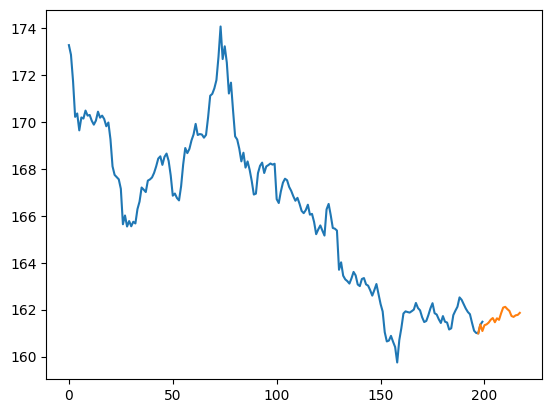

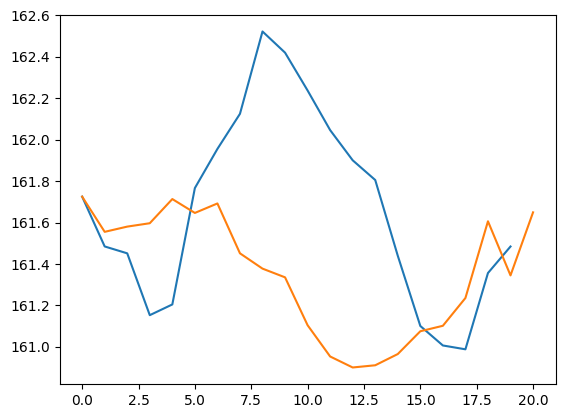

In [58]:
with torch.inference_mode():
  model.eval()

  hist = x_test_batch[-3].numpy()

  preds = []
  preds_open = [x_open[-3]]
  for i in range(20):
    pred1 = ss.inverse_transform(model(torch.from_numpy(hist).unsqueeze(0)).numpy().reshape(-1, 1))
    preds.append(pred1)
    hist = np.roll(hist, -1)
    hist[-1] = pred1.squeeze().squeeze()
    print(preds_open[-1], pred1)
    preds_open.append(preds_open[-1] + pred1.squeeze().squeeze())


  plt.plot(x_open)
  plt.plot(np.arange(len(x_open) - 3, len(x_open) + len(preds_open) - 3, 1), preds_open)
  plt.show()

  x_open = dataset_gold['Close'].values[-100:]

  a = 20
  hist = x_test_batch[-a].numpy()

  preds_open = [x_open[-a]]
  for i in range(20):
    pred1 = ss.inverse_transform(model(torch.from_numpy(hist).unsqueeze(0)).numpy().reshape(-1, 1))
    hist = np.roll(hist, -1)
    hist[-1] = pred1.squeeze().squeeze()
    preds_open.append(preds_open[-1] + pred1.squeeze().squeeze())


  plt.show()
  plt.plot(x_open[-a:])
  plt.plot(preds_open)
